In [1]:

import math
import sklearn as s 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200) 
from sklearn.preprocessing import StandardScaler 
from scipy.spatial.distance import pdist, cdist 

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score 
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')


In [2]:

MainDataSet = pd.read_csv('./district_density.csv') 
MainDataSet.head()


,Unnamed: 0,cd_code,cluster,region,dem_perc,gop_perc,dem_margin,clinton_margin,swing
0,1,AL-01,Rural-suburban mix,South,36.8,63.2,-26.4,-29.2,2.8
1,2,AL-02,Pure rural,South,38.4,61.4,-23.0,-31.7,8.7
2,3,AL-03,Pure rural,South,36.2,63.7,-27.5,-33.0,5.5
3,4,AL-04,Pure rural,South,20.1,79.8,-59.6,-62.5,2.9
4,5,AL-05,Rural-suburban mix,South,38.9,61.0,-22.1,-32.9,10.8


# 1) Main Data Pre-processing 

In [3]:

MainDataSet.columns


Index(['Unnamed: 0', 'cd_code', 'cluster', 'region', 'dem_perc', 'gop_perc',
       'dem_margin', 'clinton_margin', 'swing'],
      dtype='object')

In [4]:

MainDataSet.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435 entries, 0 to 434
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      435 non-null    int64  
 1   cd_code         435 non-null    object 
 2   cluster         435 non-null    object 
 3   region          435 non-null    object 
 4   dem_perc        435 non-null    float64
 5   gop_perc        435 non-null    float64
 6   dem_margin      435 non-null    float64
 7   clinton_margin  435 non-null    float64
 8   swing           394 non-null    float64
dtypes: float64(5), int64(1), object(3)
memory usage: 30.7+ KB


In [5]:
Missingdata = pd.DataFrame({'total_missing': MainDataSet.isnull().sum()})
Missingdata

,total_missing
Unnamed: 0,0
cd_code,0
cluster,0
region,0
dem_perc,0
gop_perc,0
dem_margin,0
clinton_margin,0
swing,41


In [6]:

# Filling the missing values with the average. 

# Num_swing
avg_swing  = MainDataSet["swing"].astype('float').mean(axis=0)
avg_swing  = math.ceil(avg_swing ) 

MainDataSet["swing"].replace(np.nan, avg_swing , inplace=True)   
print("Average of number of swing is :", avg_swing)   

MainDataSet.isnull().sum()




Average of number of swing is : 6


Unnamed: 0        0
cd_code           0
cluster           0
region            0
dem_perc          0
gop_perc          0
dem_margin        0
clinton_margin    0
swing             0
dtype: int64

In [7]:

# Changing the name of the column  
MainDataSet.rename(columns = {'Unnamed: 0':'Index','cd_code':'district code', 'cluster':'type of district', 'region':'Region', 'gop_perc':'GOP Percentage', 'dem_margin':'Demographic Margin', 'clinton_margin':'Settlement Margin',  'dem_perc':'Demographic Percentage', 'swing':'Swing' }, inplace = True)
MainDataSet.head()


,Index,district code,type of district,Region,Demographic Percentage,GOP Percentage,Demographic Margin,Settlement Margin,Swing
0,1,AL-01,Rural-suburban mix,South,36.8,63.2,-26.4,-29.2,2.8
1,2,AL-02,Pure rural,South,38.4,61.4,-23.0,-31.7,8.7
2,3,AL-03,Pure rural,South,36.2,63.7,-27.5,-33.0,5.5
3,4,AL-04,Pure rural,South,20.1,79.8,-59.6,-62.5,2.9
4,5,AL-05,Rural-suburban mix,South,38.9,61.0,-22.1,-32.9,10.8


# 2 ) Describition of Data

In [8]:

MainDataSet.describe().T


,count,mean,std,min,25%,50%,75%,max
Index,435.0,218.000000,125.717938,1.0,109.50,218.0,326.50,435.0
Demographic Percentage,435.0,54.775172,19.827270,0.0,40.25,51.7,68.35,100.0
GOP Percentage,435.0,43.402299,20.864261,0.0,30.90,47.5,59.25,100.0
Demographic Margin,435.0,11.367586,40.528343,-100.0,-18.70,4.5,37.65,100.0
Settlement Margin,435.0,3.181609,33.534941,-62.8,-22.50,-2.2,25.85,88.6
Swing,435.0,5.321379,6.877605,-19.0,1.50,5.3,8.50,36.6


 # 3) Data Quantiles

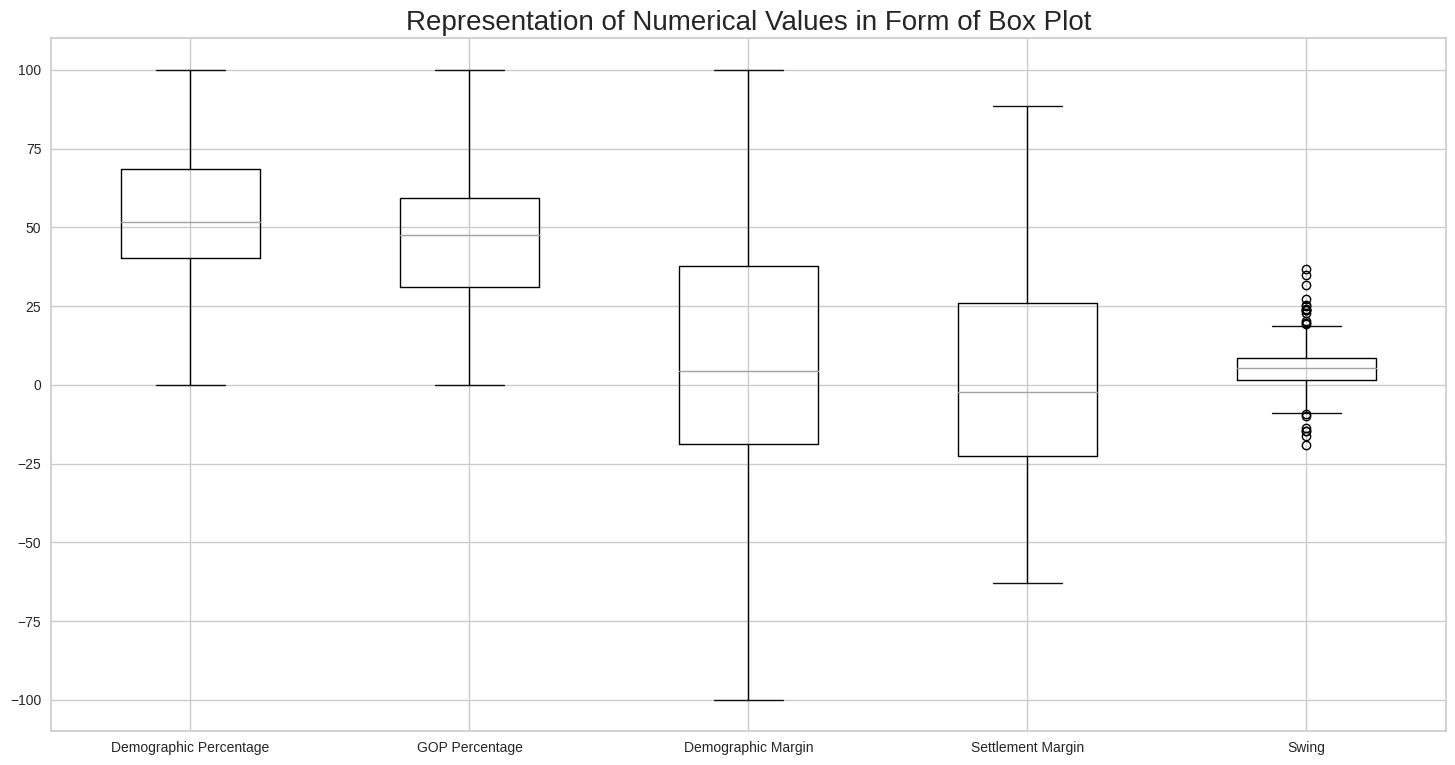

In [9]:
# Drawing boxplot for the numerical values 
Columns = ['Demographic Percentage', 'GOP Percentage', 'Demographic Margin', 'Settlement Margin', 'Swing']
plt.figure(figsize=(18,9))
MainDataSet[Columns].boxplot()
plt.title("Representation of Numerical Values in Form of Box Plot", fontsize=20)
plt.show()


# 4 ) Sorting the DataFrame based on the Settlement Margin Values 

In [10]:

# sorting the values based on settlement margin
MainDataSet = MainDataSet.sort_values(by=['Settlement Margin'])
MainDataSet


,Index,district code,type of district,Region,Demographic Percentage,GOP Percentage,Demographic Margin,Settlement Margin,Swing
373,374,TX-13,Rural-suburban mix,South,16.9,81.5,-64.6,-62.8,-1.8
3,4,AL-04,Pure rural,South,20.1,79.8,-59.6,-62.5,2.9
171,172,KY-05,Pure rural,South,21.0,78.9,-57.9,-62.1,4.2
122,123,GA-09,Pure rural,South,20.5,79.5,-59.0,-58.5,-0.5
371,372,TX-11,Rural-suburban mix,South,18.4,80.1,-61.7,-58.5,-3.2
...,...,...,...,...,...,...,...,...,...
138,139,IL-07,Pure urban,Midwest,87.6,12.4,75.2,77.3,-2.1
33,34,CA-13,Pure urban,West,88.4,0.0,88.4,79.3,6.0
326,327,PA-03,Pure urban,Northeast,93.4,6.6,86.8,83.9,2.9
269,270,NY-13,Pure urban,Northeast,94.6,5.4,89.2,86.4,2.8


 # 5 ) Joined plot for the Settlement Margin and the Demographic Precentage Features

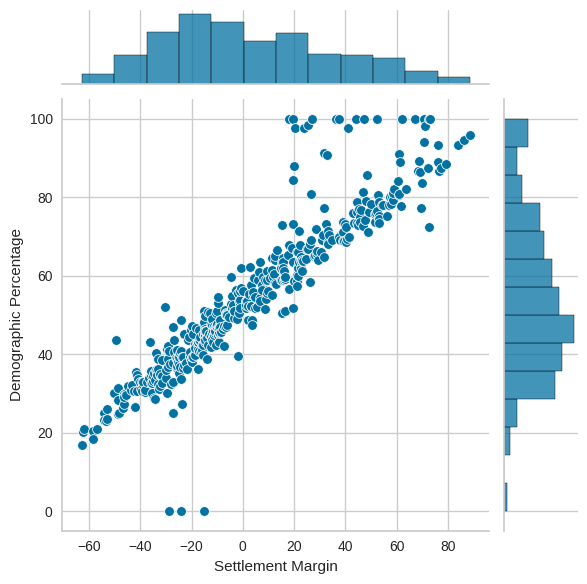

In [11]:
# visualize the sorted values 

sns.jointplot(data=MainDataSet, x="Settlement Margin", y="Demographic Percentage")




# 6 ) Distribution Plots 
## Visualization with Density plots
### 6-1) Density plot for 	Demographic Percentage

Text(0, 0.5, 'The entire population Percentage')

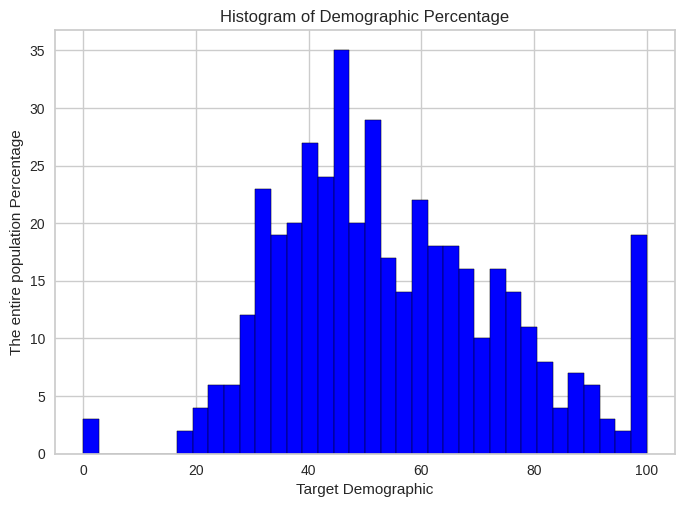

In [12]:

# Density plot for 	Demographic Percentage
# target demographic by the entire population

plt.hist(MainDataSet['Demographic Percentage'], color = 'blue', edgecolor = 'black',bins = int(180/5))

# seaborn histogram
sns.distplot(MainDataSet['Demographic Percentage'], hist=True, kde=False, bins=int(180/5), color = 'blue', hist_kws={'edgecolor':'black'})

# Add labels
plt.title('Histogram of Demographic Percentage')
plt.xlabel('Target Demographic')
plt.ylabel('The entire population Percentage')



<Axes: xlabel='Demographic Percentage', ylabel='Density'>

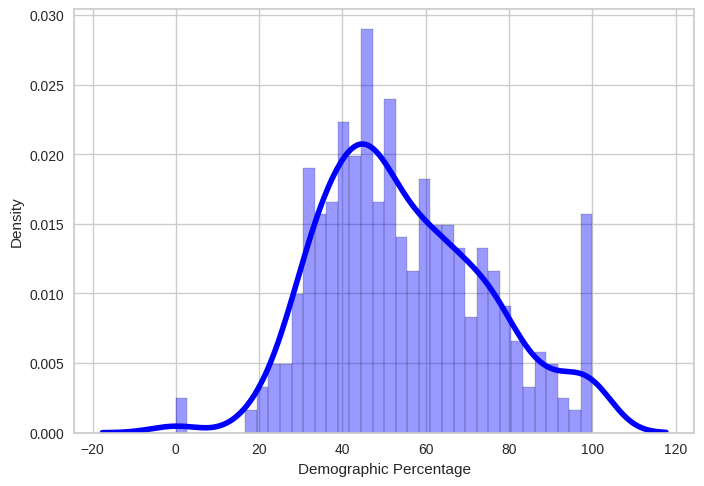

In [13]:

sns.distplot(MainDataSet['Demographic Percentage'], hist=True, kde=True, 
             bins=int(180/5), color = 'blue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})


### 6-2) Density Plot for 	GOP Percentage

Text(0, 0.5, 'The entire population')

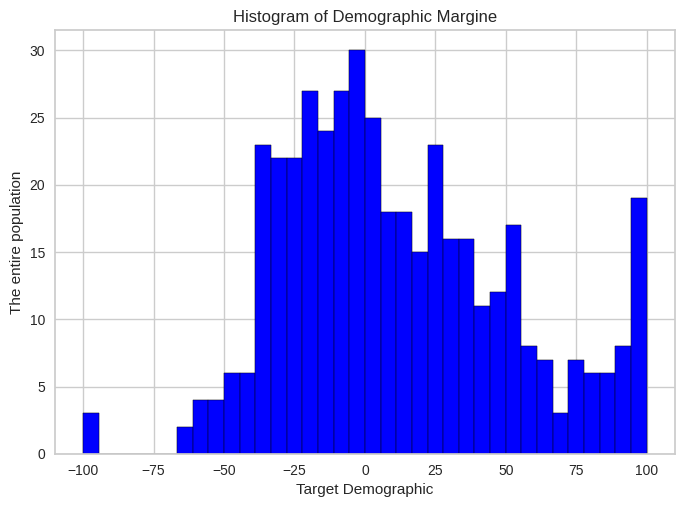

In [14]:

plt.hist(MainDataSet['Demographic Margin'], color = 'blue', edgecolor = 'black',bins = int(180/5)) 

# seaborn histogram
sns.distplot(MainDataSet['Demographic Margin'], hist=True, kde=False, bins=int(180/5), color = 'blue', hist_kws={'edgecolor':'black'})

# Add labels
plt.title('Histogram of Demographic Margine')

plt.xlabel('Target Demographic')
plt.ylabel('The entire population')



<Axes: xlabel='Demographic Margin', ylabel='Density'>

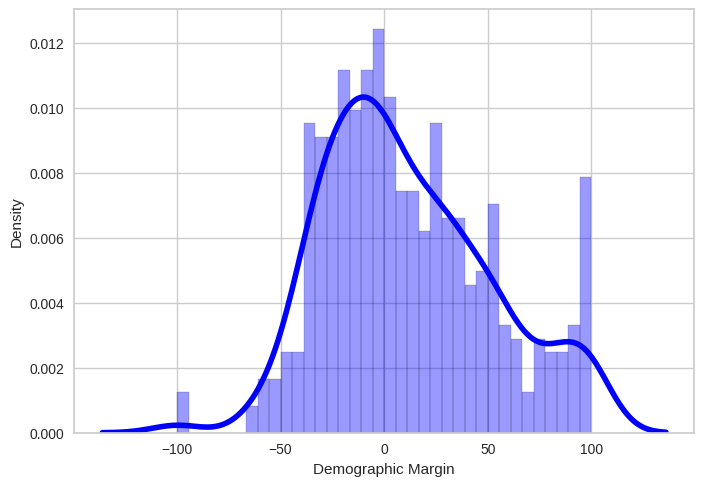

In [15]:

sns.distplot(MainDataSet['Demographic Margin'], hist=True, kde=True, 
             bins=int(180/5), color = 'blue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})



## 6-3 ) Density Plot for Settlement Margin

Text(0, 0.5, 'The entire population')

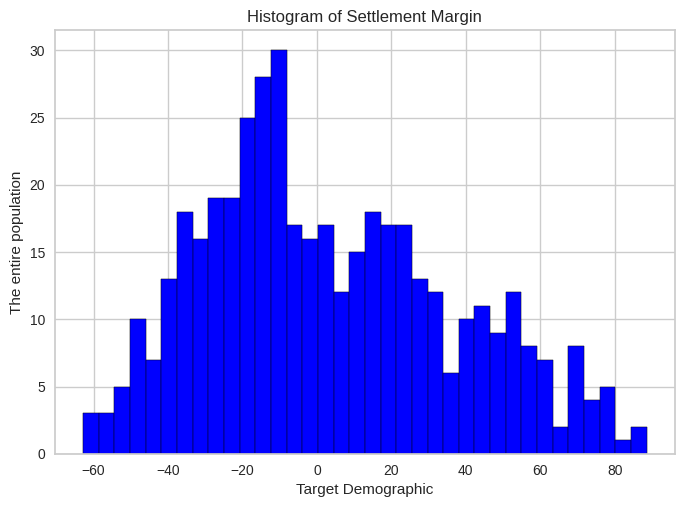

In [16]:

plt.hist(MainDataSet['Settlement Margin'], color = 'blue', edgecolor = 'black',bins = int(180/5)) 

# seaborn histogram
sns.distplot(MainDataSet['Settlement Margin'], hist=True, kde=False, bins=int(180/5), color = 'blue', hist_kws={'edgecolor':'black'})

# Add labels
plt.title('Histogram of Settlement Margin')

plt.xlabel('Target Demographic')
plt.ylabel('The entire population')



<Axes: xlabel='Settlement Margin', ylabel='Density'>

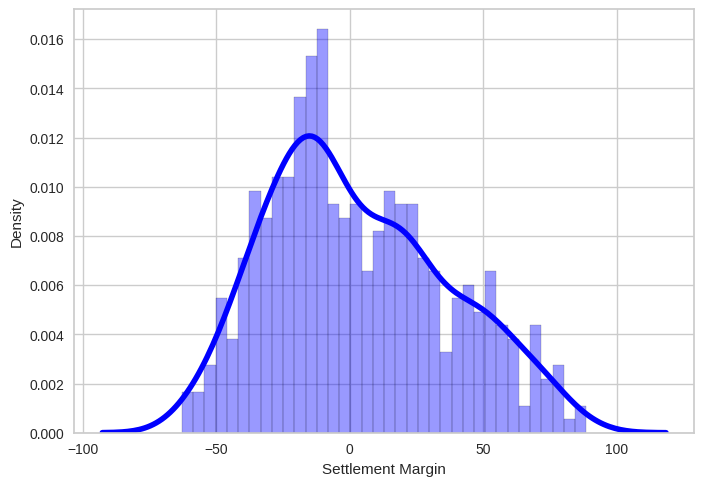

In [17]:

sns.distplot(MainDataSet['Settlement Margin'], hist=True, kde=True, 
             bins=int(180/5), color = 'blue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})




## 7) Scatter Plot For Demographic Percentage based on Swign


<Axes: xlabel='Demographic Percentage', ylabel='Swing'>

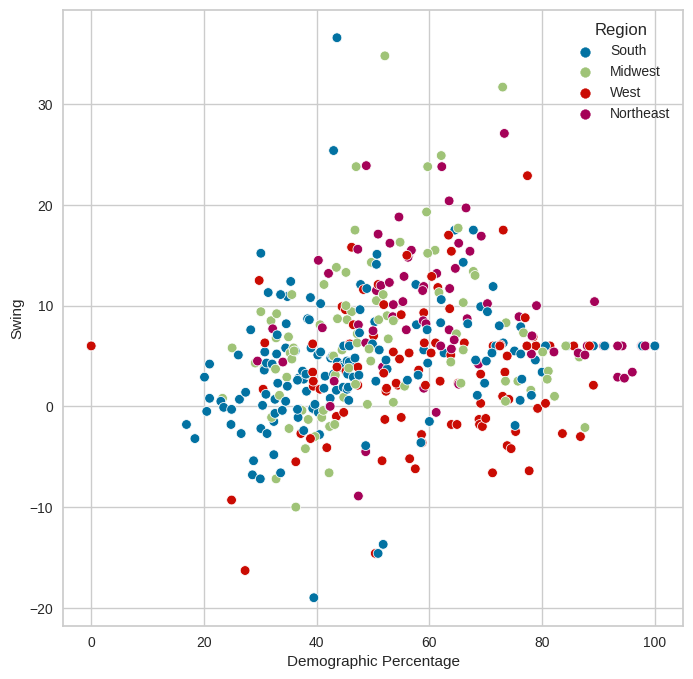

In [18]:

plt.figure(figsize=(8, 8))
sns.scatterplot(x= "Demographic Percentage", y="Swing", data = MainDataSet, hue="Region")


## 7-1) Scatter Plot For Demographic Margin based on Swing


<Axes: xlabel='Demographic Margin', ylabel='Swing'>

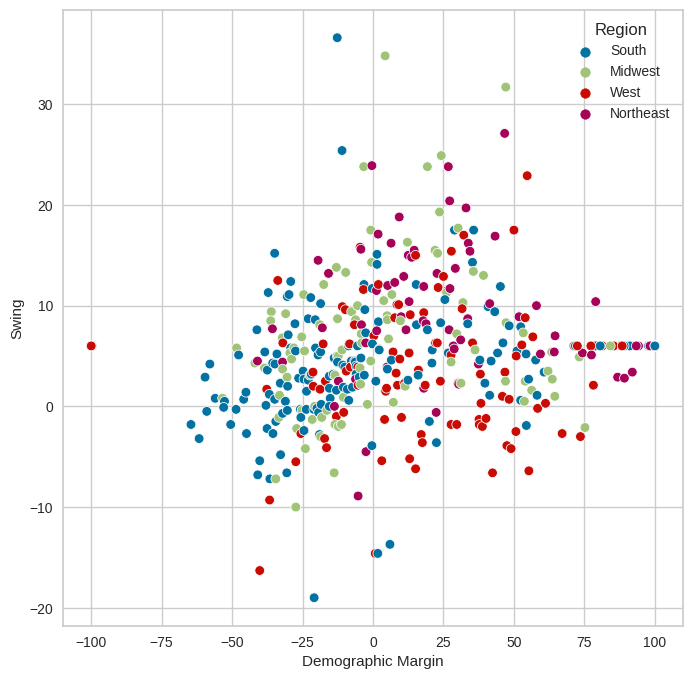

In [19]:

plt.figure(figsize=(8, 8))
sns.scatterplot(x= "Demographic Margin", y="Swing", data = MainDataSet, hue="Region")



## 7-2) Scatter Plot For Settlement Margin based on Swing

<Axes: xlabel='Settlement Margin', ylabel='Swing'>

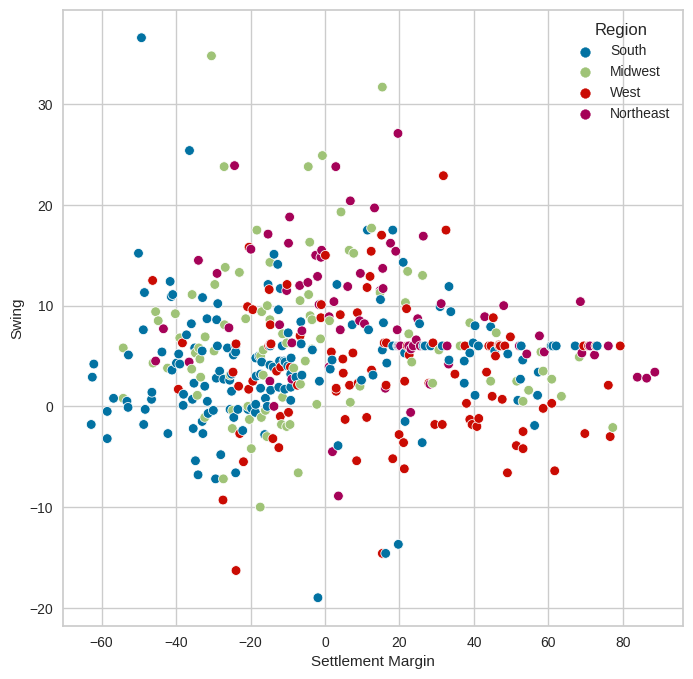

In [20]:


plt.figure(figsize=(8, 8))
sns.scatterplot(x= "Settlement Margin", y="Swing", data = MainDataSet, hue="Region")


# 8) Calculating Pearson's correlations

In [21]:
import numpy as np
from scipy import stats

correlation_1, _ =  stats.pearsonr(MainDataSet['Demographic Percentage'], MainDataSet['Swing'])
correlation_2, _ =  stats.pearsonr(MainDataSet['Demographic Margin'], MainDataSet['Swing'])
correlation_3, _ = stats.pearsonr(MainDataSet['Settlement Margin'], MainDataSet['Swing'])


print(correlation_1)
print(correlation_2)
print(correlation_3)


0.16115567762122565
0.16161870410642842
-0.01821297797513589


# 9 ) Finding the Right Number of Clusters 
## The K-Elbow Method

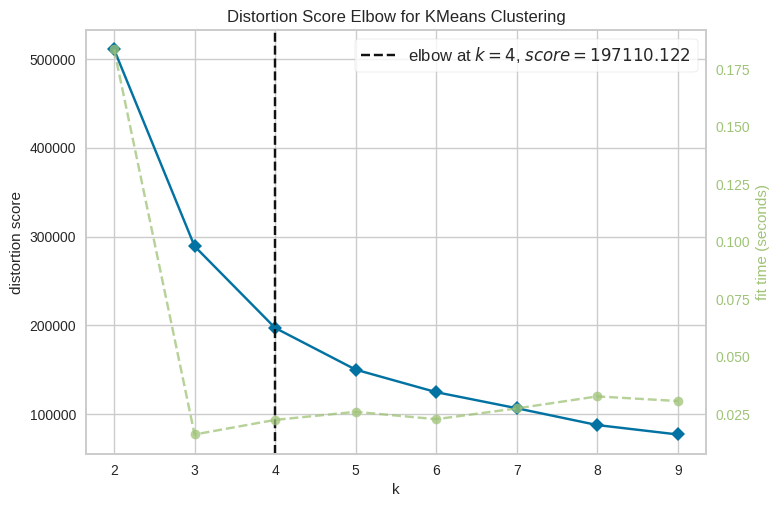

In [22]:
# Separating The Numeric Values
X_numerics = MainDataSet[['Demographic Percentage',	'GOP Percentage',	'Demographic Margin',	'Settlement Margin',	'Swing']] 

model_1 = KMeans(random_state=1)

visualizer = KElbowVisualizer(model_1, k=(2,10))
visualizer.fit(X_numerics)
visualizer.show()
plt.show()


## 9-1) The K-Elbow Method with Silhouette Metric

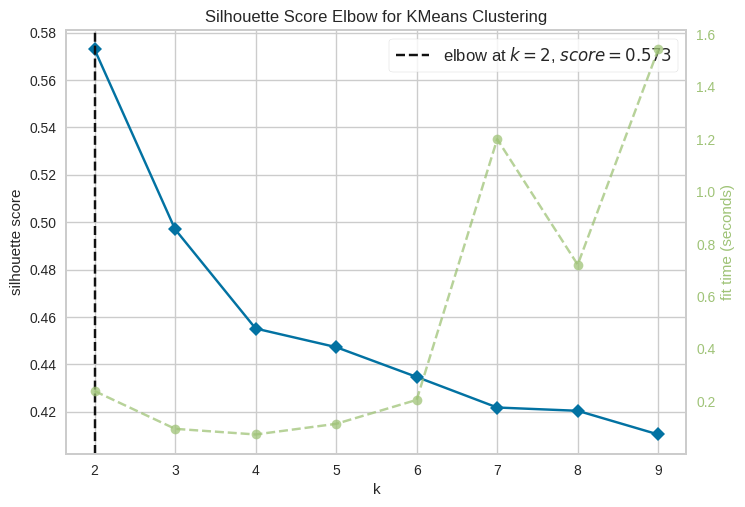

In [23]:

model_2 = KMeans(random_state=1)
visualizer = KElbowVisualizer(model_2, k=(2,10), metric='silhouette') 
visualizer.fit(X_numerics)
visualizer.show()
plt.show()


## 10 ) Plotly 3D Visualization 

In [24]:

import plotly.express as px
  
fig = px.scatter_3d(MainDataSet, x = 'Demographic Margin', 
                    y = 'Settlement Margin', 
                    z = 'Swing',
                    color = 'Region')
  
fig.show() 


## 11 ) The Kmeans Clustering Algorithm

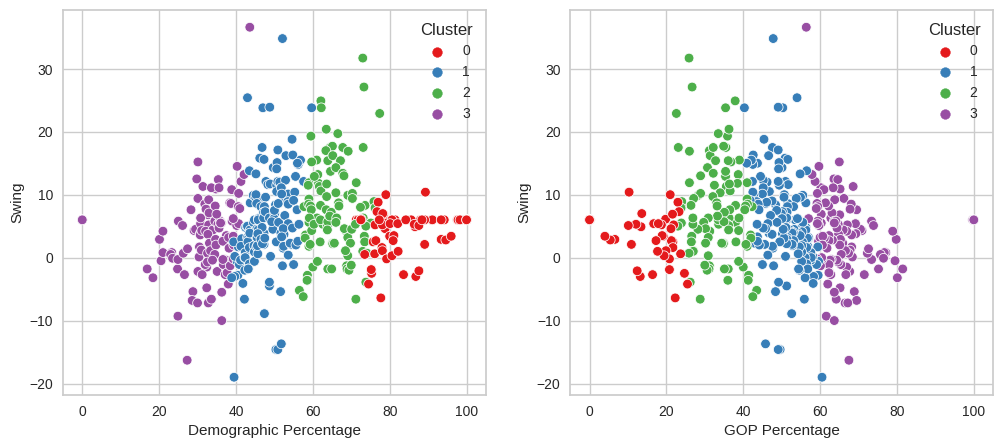

In [25]:
KM_5_clusters = KMeans(n_clusters=4, init='k-means++').fit(X_numerics)

KM5_clustered = X_numerics.copy() 

KM5_clustered.loc[:,'Cluster'] = KM_5_clusters.labels_ 

fig1, (axes) = plt.subplots(1,2, figsize=(12, 5))

sns.scatterplot(x ='Demographic Percentage', y ='Swing', data = KM5_clustered, hue='Cluster',  palette = 'Set1', ax = axes[0], legend='full')

sns.scatterplot(x ='GOP Percentage', y ='Swing', data= KM5_clustered, hue='Cluster', palette = 'Set1', ax=axes[1], legend='full')

#axes[0].scatter(KM_5_clusters.cluster_centers_[:,0], KM_5_clusters.cluster_centers_[:,1], marker='x', s=40, c="blue")
#axes[1].scatter(KM_5_clusters.cluster_centers_[:,0], KM_5_clusters.cluster_centers_[:,1], marker='x', s=40, c="blue")

plt.show()



# 12 ) Model Evaluation for Clustering

0.6984864651545899
1008.6755767069988
0.45509153313217326


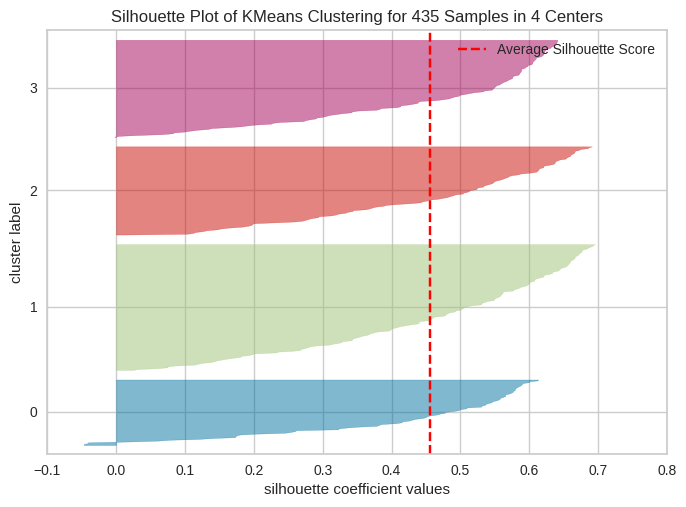

In [26]:
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score 
from sklearn.metrics import silhouette_score



# davies_bouldin_score
print(davies_bouldin_score(X_numerics, KM_5_clusters.labels_)) 

# calinski_harabasz_score
print(calinski_harabasz_score(X_numerics, KM_5_clusters.labels_ ))


# the silhouette_score visualizition
print(silhouette_score(X_numerics, KM_5_clusters.labels_)) 
visualizer = SilhouetteVisualizer(KM_5_clusters, colors ='yellowbrick')
visualizer.fit(X_numerics)
visualizer.show()
plt.show() 



# 13 ) Normalizing The Data
## We use Normalized Data for Other Algorithms 

In [27]:
# Normalize and Transform 
from sklearn.preprocessing import normalize

scaler = StandardScaler() 
scaled_df = scaler.fit_transform(X_numerics) 

data_scaled = normalize(scaled_df)
data_scaled = pd.DataFrame(data_scaled, columns=X_numerics.columns)
data_scaled.head() 

# Apply Principle Component Anaylsis for visualizing the data in 2D space.




,Demographic Percentage,GOP Percentage,Demographic Margin,Settlement Margin,Swing
0,-0.486145,0.464697,-0.477028,-0.500725,-0.263512
1,-0.482675,0.481471,-0.483282,-0.540562,-0.097168
2,-0.481167,0.480572,-0.482761,-0.549863,-0.046055
3,-0.477695,0.478091,-0.479786,-0.508267,-0.233896
4,-0.479677,0.459878,-0.471382,-0.480912,-0.323951


# 14 ) Performing Principal Component Analysis

In [28]:

pca = PCA()
pca_data = pca.fit_transform(X_numerics)
pca_data = pd.DataFrame(pca_data, columns=["pc"+str(i+1) for i in range(len(X_numerics.columns))])
print("pca.explained variance ratio:\n ", " ".join(map("{:.3f}".format, pca.explained_variance_ratio_)))


pca.explained variance ratio:
  0.951 0.038 0.009 0.002 0.000


## 15 ) Display Principal Component Analysis

In [29]:

pca_data.head


<bound method NDFrame.head of             pc1        pc2       pc3       pc4       pc5
0    114.058338  -2.103677 -6.862072  0.711651  0.001977
1    108.755501  -6.563826 -3.534673 -0.393844  0.059315
2    106.743341  -7.782943 -2.628429 -0.412189  0.001440
3    105.962457  -2.620425 -5.727618 -0.472703  0.002107
4    108.752201  -0.034916 -7.652753  0.611882  0.002283
..          ...        ...       ...       ...       ...
430 -105.864395  21.197949 -1.376172 -1.812334  0.006533
431 -120.687967  11.415135  3.083553  6.119823  0.004450
432 -121.429166  17.418555  2.344166 -1.927094  0.006159
433 -125.255564  17.925627  2.375526 -1.951066  0.006249
434 -129.336813  17.702924  2.878547 -1.978889  0.006248

[435 rows x 5 columns]>

# 16 ) DBSCAN clustering

In [30]:

from sklearn.cluster import DBSCAN

DBSCAN_clustered = pca_data.copy() 

DBSCAN_clustering = DBSCAN(eps=3, min_samples=2).fit(pca_data)

DBSCAN_Predicted_Features = DBSCAN_clustering.labels_

DBSCAN_clustering.labels_



array([-1,  0,  0, -1, -1, -1,  1,  2,  2,  2,  1, -1, -1, -1, -1, -1, -1,
        3,  3, -1,  4,  5,  4,  5,  6,  5,  6, -1,  7,  7,  6,  7,  7,  6,
        6,  6,  6, -1, -1,  6,  6, -1,  8, -1, -1,  8, -1,  8, -1,  8,  9,
       10,  9,  8, 10, -1,  9,  9,  9,  9,  9, 11,  9,  9,  9, -1, 11,  9,
        9, -1,  9, -1, 12, -1, 13, -1, 12, -1, 12, 13, -1, -1, -1, 13, -1,
       12, -1, 13, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, -1, -1, 13,
       -1, 13, -1, -1, 13, -1, 13, 13, -1, 14, 14, 15, 15, 15, 16, 15, 16,
       13, 15, 14, 15, 15, 15, 15, 15, -1, 15, -1, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 15, 17, 18, -1, 18, 17, 15, 15, 15, 15,
       15, 15, 15, 15, -1, 15, 15, 17, 15, 17, 15, 15, -1, 15, 15, 15, 19,
       15, 15, 15, 15, 15, 15, 15, 15, 19, 15, 15, 19, 15, 15, -1, 15, -1,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, -1, 20, 21, 20, 15, 21,
       21, 15, 21, 21, 22, -1, 22, 23, 24, 24, 25, 25, 23, -1, 23, -1, 26,
       -1, -1, 26, 23, 26

# 18 ) Model Evaluation

In [31]:


# davies_bouldin_score
print(davies_bouldin_score(pca_data, DBSCAN_clustering.labels_)) 

# calinski_harabasz_score
print(calinski_harabasz_score(pca_data, DBSCAN_clustering.labels_ ))


# the silhouette_score
print(silhouette_score(pca_data, DBSCAN_clustering.labels_)) 

visualizer = SilhouetteVisualizer(DBSCAN_clustering, colors ='yellowbrick')

# visualizer.fit(pca_data)
# visualizer.show()
# plt.show() 



2.797909075099227
6.626323991883679
-0.04184896238836251


# 19) 3D Visualization of DBSCAN clustering

In [32]:
import matplotlib.pyplot as plt 
import seaborn as sns

import plotly as py
import plotly.graph_objs as go 


pca_data['cluster'] = pd.DataFrame(DBSCAN_Predicted_Features)

trace1 = go.Scatter3d(x= MainDataSet['Demographic Margin'], y= MainDataSet['Settlement Margin'], z= MainDataSet['Swing'], mode='markers', marker=dict(color = pca_data['cluster'], size= 10, line=dict(color= pca_data['cluster'], width= 12 ), opacity=0.8 ))


data = [trace1]
layout = go.Layout(title= '3D Visualization of DBSCAN clustering',scene = dict( xaxis = dict(title  = 'Demographic Margin'), yaxis = dict(title  = 'Settlement Margin'), zaxis = dict(title  = 'Swing')))
fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)






# 20 ) Agglomerative Clustering 


In [33]:


from sklearn.cluster import AgglomerativeClustering 

Agglomerative_clustering = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')  
Agglomerative_clustering_Predicted_Features = Agglomerative_clustering.fit_predict(pca_data)
Agglomerative_clustering_Predicted_Features




array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2,
       2, 1, 1, 2, 2, 2, 1, 2, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1,
       1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 3, 1, 3, 1, 3, 1, 3, 1,
       3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 1, 1, 3, 3, 1, 1, 0, 3, 1, 3, 3, 3,
       3, 1, 3, 3, 3, 3, 0, 3, 1, 3, 1, 0, 0, 1, 0,

# 21 ) Model Evaluation 

In [34]:

# davies_bouldin_score
print(davies_bouldin_score(pca_data, Agglomerative_clustering_Predicted_Features)) 

# calinski_harabasz_score
print(calinski_harabasz_score(pca_data, Agglomerative_clustering_Predicted_Features ))


# the silhouette_score
print(silhouette_score(pca_data, Agglomerative_clustering_Predicted_Features)) 


0.8444077585847882
559.49773903432
0.3603134635193826


# 22 ) 3D Visualization of Agglomerative Clustering

In [35]:

pca_data['cluster'] = pd.DataFrame(Agglomerative_clustering_Predicted_Features)


trace1 = go.Scatter3d(x= MainDataSet['Demographic Margin'], y= MainDataSet['Settlement Margin'], z= MainDataSet['Swing'], mode='markers', marker=dict(color = pca_data['cluster'], size= 10, line=dict(color= pca_data['cluster'], width= 12 ), opacity=0.8 ))

data = [trace1]

layout = go.Layout(title= '3D Visualization of Agglomerative Clustering',scene = dict( xaxis = dict(title  = 'Demographic Margin'), yaxis = dict(title  = 'Settlement Margin'), zaxis = dict(title  = 'Swing')))

fig = go.Figure(data=data, layout=layout)

py.offline.iplot(fig)




# 23 ) Hierarchy Clustering 

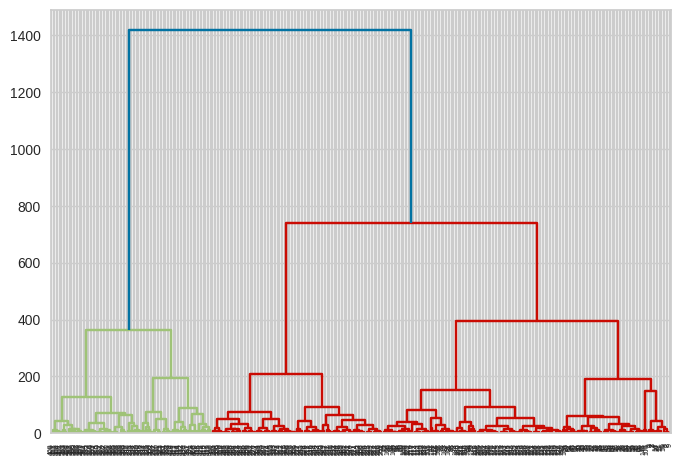

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as shc

Dendrogram = shc.dendrogram((shc.linkage(pca_data, method ='ward'))) 

# plt.figure(figsize =(6, 6)) 
# plt.title('Visualising the data') 


# 24 ) Performing Decomposition 
## 24-1) SVD Decompoition 

In [59]:

First_array =X_numerics.to_numpy(dtype=float)
u, s, vh = np.linalg.svd(First_array, full_matrices=True)
print(u.shape)
print(s.shape)
print(vh.shape)


(435, 435)
(5,)
(5, 5)


In [60]:

print(u)


[[-0.00985536  0.10357025 -0.00837951 ... -0.07089001 -0.07166632
  -0.07245748]
 [-0.01241879  0.10020018 -0.02633352 ...  0.06646131  0.06904792
   0.07190874]
 [-0.01312242  0.09874258 -0.03130739 ...  0.01930922  0.01985975
   0.02042735]
 ...
 [-0.08147986 -0.07420964  0.07220465 ...  0.98283923 -0.01759649
  -0.01788996]
 [-0.08261954 -0.07711447  0.07428511 ... -0.01760067  0.98195061
  -0.01835058]
 [-0.08388906 -0.08017661  0.073386   ... -0.01791098 -0.01836773
   0.98130505]]


# 25 ) K-means Clustering on SVD Decomposition 

In [61]:

kmeans_svd = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0) 

kmeans_svd_prediction = kmeans_svd.fit_predict(u) 



# 26 ) Clustered SVD Decomposition 3D visualization 

In [62]:


pca_data['cluster'] = pd.DataFrame(kmeans_svd_prediction) 

trace1 = go.Scatter3d(x= MainDataSet['Demographic Margin'], y= MainDataSet['Settlement Margin'], z= MainDataSet['Swing'], mode='markers', marker=dict(color = pca_data['cluster'], size= 10, line=dict(color= pca_data['cluster'], width= 12 ), opacity=0.8 ))

data = [trace1]

layout = go.Layout(title= '3D Visualization of Agglomerative Clustering',scene = dict( xaxis = dict(title  = 'Demographic Margin'), yaxis = dict(title  = 'Settlement Margin'), zaxis = dict(title  = 'Swing')))

fig = go.Figure(data=data, layout=layout)

py.offline.iplot(fig)


# 27 ) Model Evaluation for SVD 

In [58]:

# davies_bouldin_score
print(davies_bouldin_score(pca_data, kmeans_svd_prediction)) 

# calinski_harabasz_score
print(calinski_harabasz_score(pca_data, kmeans_svd_prediction))


# the silhouette_score
print(silhouette_score(pca_data, kmeans_svd_prediction)) 


1.4902002789631126
1.9459535624540314
-0.4838340241862064


# 28 ) Eigenvalues and Eigenvectors

In [63]:

from numpy.linalg import eig

First_array =X_numerics.to_numpy(dtype=float)

print(First_array.shape)

w,v=eig(u)

print(w.shape)
print(v.shape)

print(v)


(435, 5)
(435,)
(435, 435)
[[ 5.00892101e-01+0.j          5.00892101e-01-0.j
  -1.70317257e-02-0.0106529j  ... -2.95384670e-15+0.j
   1.63306634e-16+0.j          1.99204920e-15+0.j        ]
 [-4.44051332e-02+0.09346021j -4.44051332e-02-0.09346021j
  -1.61427718e-02+0.05211906j ...  1.86233656e-16+0.j
  -3.31229232e-18+0.j         -9.28281487e-17+0.j        ]
 [ 1.36174748e-02-0.27460274j  1.36174748e-02+0.27460274j
   4.25628060e-01+0.j         ... -1.35152456e-15+0.j
   3.09813389e-16+0.j          1.71813911e-18+0.j        ]
 ...
 [ 3.89945438e-02+0.03046014j  3.89945438e-02-0.03046014j
  -1.50697677e-02-0.02346819j ... -1.99879024e-02+0.j
   4.80110486e-02+0.j         -1.19921002e-02+0.j        ]
 [ 3.95161505e-02+0.03121059j  3.95161505e-02-0.03121059j
  -1.56056475e-02-0.02416545j ...  1.49474468e-02+0.j
  -8.34604241e-03+0.j         -1.54734461e-02+0.j        ]
 [ 4.01622402e-02+0.03233531j  4.01622402e-02-0.03233531j
  -1.40333235e-02-0.02382209j ...  1.16690024e-02+0.j
  -4.6046

# 29 ) K-means Decompostion for Eigenvalues and Eigenvectors

In [67]:

# Clustering after EigenValue Decomposition
u_2 = v.real

kmeans_Eigenvalues = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0) 
kmeans_Eigenvalues_prediction = kmeans_Eigenvalues.fit_predict(u_2) 


# 30) 3D visualization of Eigenvalues and Eigenvectors Decomposition

In [68]:


pca_data['cluster'] = pd.DataFrame(kmeans_Eigenvalues_prediction) 

trace1 = go.Scatter3d(x= MainDataSet['Demographic Margin'], y= MainDataSet['Settlement Margin'], z= MainDataSet['Swing'], mode='markers', marker=dict(color = pca_data['cluster'], size= 10, line=dict(color= pca_data['cluster'], width= 12 ), opacity=0.8 ))

data = [trace1]

layout = go.Layout(title= '3D Visualization of Agglomerative Clustering',scene = dict( xaxis = dict(title  = 'Demographic Margin'), yaxis = dict(title  = 'Settlement Margin'), zaxis = dict(title  = 'Swing')))

fig = go.Figure(data=data, layout=layout)

py.offline.iplot(fig)


# 31 ) Model Evaluation 

In [69]:

# davies_bouldin_score
print(davies_bouldin_score(pca_data, kmeans_Eigenvalues_prediction)) 

# calinski_harabasz_score
print(calinski_harabasz_score(pca_data,kmeans_Eigenvalues_prediction))


# the silhouette_score
print(silhouette_score(pca_data, kmeans_Eigenvalues_prediction)) 


1.7372040317640678
6.74258799785489
-0.03466526776758457


# The End of The Experiment 